# Time Series Analysis

Goal: Find outliers, trends and periodicity in the MTA turnstile data

In [1]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
mta = np.load('MTA_Fare.npy')
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
mtarange = pd.date_range('05/21/2010', periods=194, freq='W')
mtarange.shape

(194,)

**MARK**

1. np.where()
2. np.sum()
3. np.nansum()
4. np.nanmean()
5. -> np.fft.rfft(mydata)

In [3]:
#using where to replace all -1 with NaN
mta = np.where(mta !=-1, mta, np.nan)
mta = mta.astype(float)
#look at shape of the data
mta.shape

(600, 23, 194)

## Task 1:
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. And identify it and figure out what it is due to.


### Answer:
The most prominent event is a significant drop around November to December, 2012. And the reason of it would possibly be the superstorm "Sandy"

In [4]:
mtastation = np.nansum(mta, axis=1)
#see the outputs after nansum
mtastation.shape

(600, 194)

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

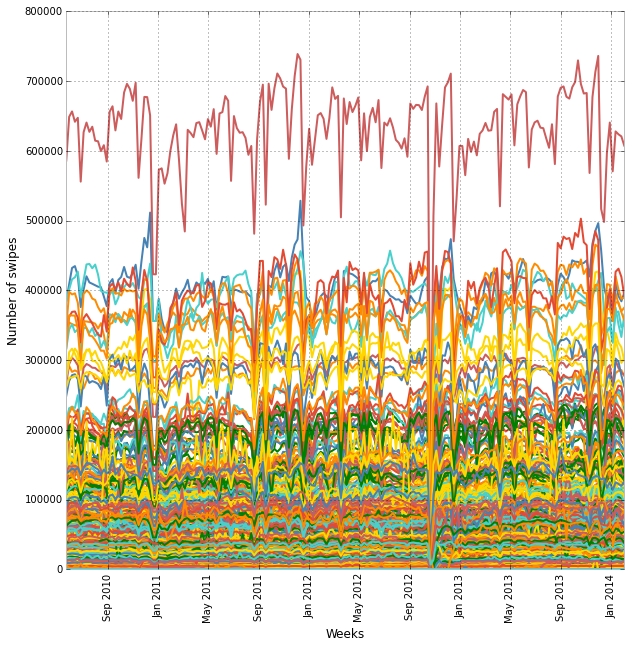

In [5]:
#plotting
plt.figure(figsize=(10,10), dpi=200)
ax = pl.plot(mtarange, np.transpose(mtastation))
pl.ylabel('Number of swipes')
pl.xlabel('Weeks')
pl.xticks(rotation = 90)

In [6]:
#find mean and std
mtastation_mean = np.nanmean(mtastation, axis=1)
mtastation_std = np.nanstd(mtastation, axis=1)
#mtastation_mean.shape
#mtastation_std.shape

In [7]:
#creating thresholds by mean +- 3 sigma
thred_lower = mtastation_mean - 3*mtastation_std
thred_upper = mtastation_mean + 3*mtastation_std
#thred_lower.shape
#thred_upper.shape

In [8]:
#finding outliers outside the range of thresholds -> significant drop
thredweeks = [np.where(item < thred_lower[i]) for i,item in enumerate(mtastation)]
#plt.figure(figsize=(10,10), dpi=200)
#ax1 = pl.plot(mtarange, np.transpose(thredweeks))

## Task 2:
Some of the times seires are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types** that have steadily increased in popularity, and that have steadily decreased. By how much? (e.g. what is the ratio of usage in the first 10 and last 10 weeks)

In [9]:
mtarider = np.nansum(mta, axis=0)/600
mtarider.shape

(23, 194)

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

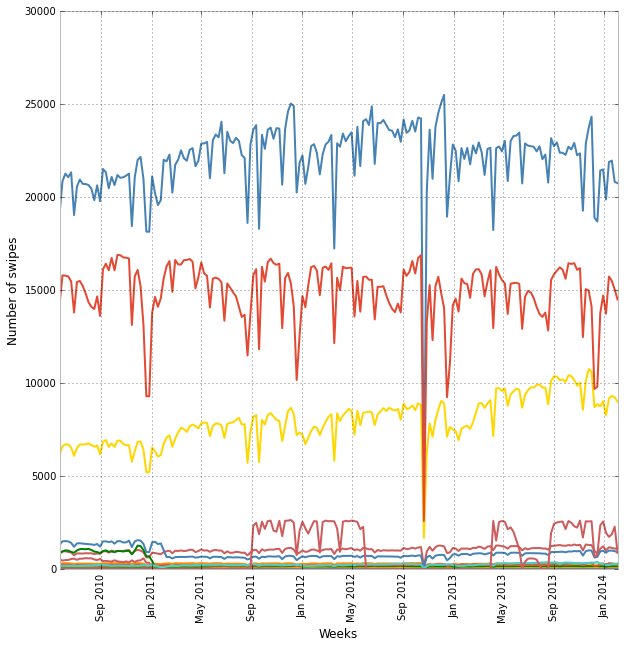

In [10]:
plt.figure(figsize=(10,10),dpi=200)
ax = pl.plot(mtarange, np.transpose(mtarider))
pl.xlabel('Weeks')
pl.ylabel('Number of swipes')
pl.xticks(rotation = 90)

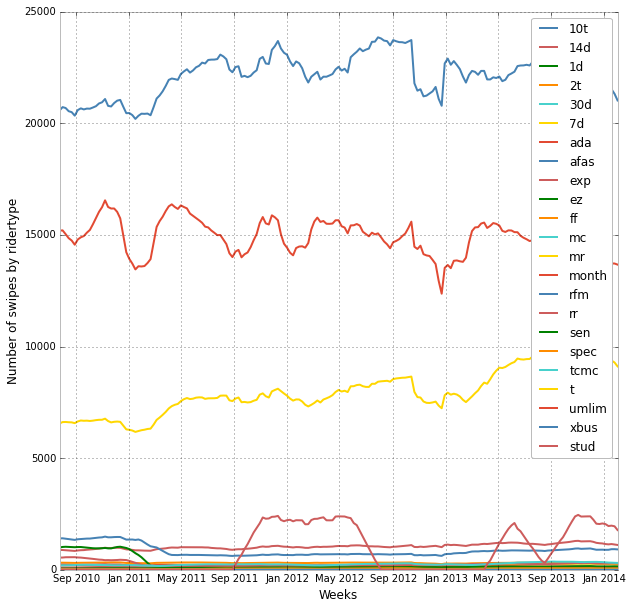

In [11]:
#averaging mean
plt.figure(figsize=(10,10), dpi=200)
smoothrider = pd.rolling_mean(np.transpose(mtarider),10)
ax = pl.plot(mtarange, smoothrider)
pl.ylabel('Number of swipes by ridertype')
pl.xlabel('Weeks')
pl.legend(ridetype)

In [12]:
ratio = smoothrider[10,:]/smoothrider[193,:]
print ratio

[  9.85855761e-01   7.96898334e-01   9.01896857e-01   1.07217516e+00
   9.83155326e-01   7.26253084e-01   1.11214933e+00   4.80765217e+03
   9.42633429e+04   6.82381555e+05   1.23714609e+00   8.30622261e-01
   3.89558171e-05   1.74222625e+00   1.54426917e+00   3.87513943e-01
   3.47208425e-01   5.46373828e-02   6.53059649e-01   9.80984190e-01
   1.26020779e+00   6.18746842e-01   0.00000000e+00]


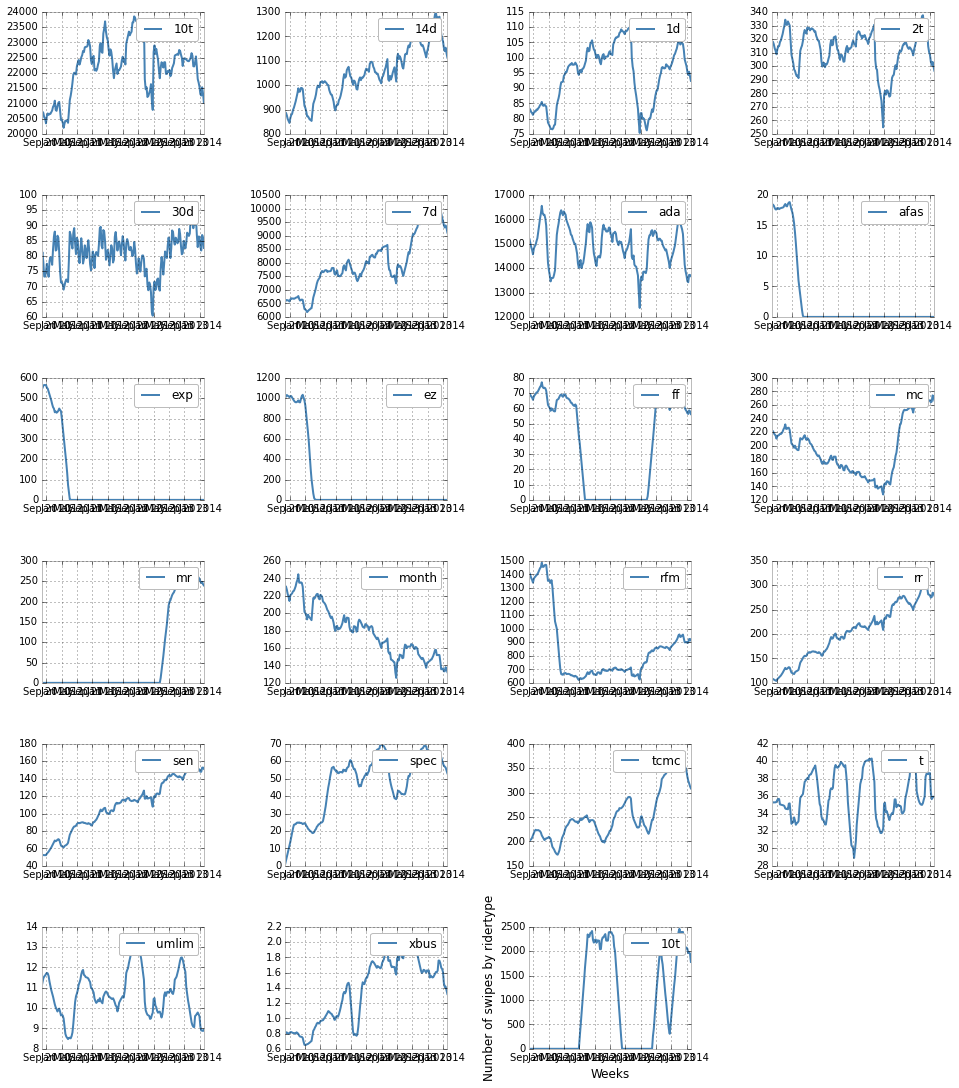

In [13]:
#differentiate data by ridership type
plt.figure(figsize=(16, 16), dpi=200)

for i in range(0,23):
    pl.subplot(6,4,i+1)
    ax = pl.plot(mtarange, smoothrider[:,i])
    pl.legend(ridetype[i:])

pl.ylabel('Number of swipes by ridertype')
pl.xlabel('Weeks')
pl.legend(ridetype)
pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

The visualizations of swipes by ridertypes show that:

* 14 day, 7 day, rail road, senior, special, tcmc, xbus increased
* monthly pass decreased

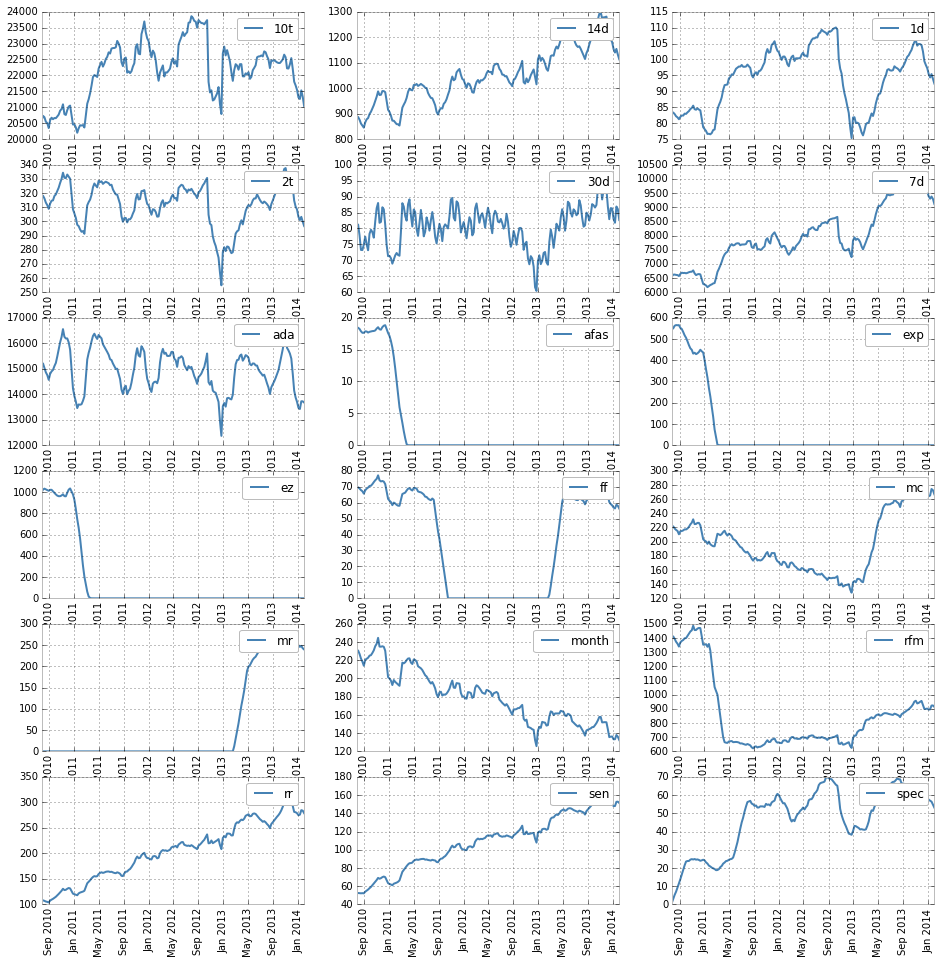

In [14]:
plt.figure(figsize=(16,16), dpi=200)
n, j = 1, 0
for i in ratio:
    if i>0.9 and i<1.1:
        continue
        j += 1
    else:
        pl.subplot(6, 3, n)
        ax = pl.plot(mtarange, smoothrider[:, j])
        pl.legend(ridetype[j:])
        pl.xticks(rotation = 90)
        n += 1
        j += 1

In [15]:
myratio = [1,5,13,15,16,17,18,21]
for i in myratio:
    if i != 13:
        print '%s passes are increasing at a ratio of %f.' % (ridetype[i], ratio[i])
    else:
        print '%s passes are decreasing at a ratio of %f.' % (ridetype[i], ratio[i])

14d passes are increasing at a ratio of 0.796898.
7d passes are increasing at a ratio of 0.726253.
month passes are decreasing at a ratio of 1.742226.
rr passes are increasing at a ratio of 0.387514.
sen passes are increasing at a ratio of 0.347208.
spec passes are increasing at a ratio of 0.054637.
tcmc passes are increasing at a ratio of 0.653060.
xbus passes are increasing at a ratio of 0.618747.


## Task 3:
Several stations show a prominent annual periodicity. Identify the 4 **stations** (identify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). Can you figure out what the periodic peak in rides is due to?

### Answer:
From figures demonstrated below, the 4 stations showing the most prominent periodic trend are 149, 193, 279, 326. This periodic peak could be due to marketing plan changes, technology change.

In [16]:
#use fourier transformation to find periodicity
fourier = np.abs(np.fft.rfft(mtastation))
fourier.shape
#there is only 98 output because only positive waves are taking into consideration

(600, 98)

In [17]:
freq = np.fft.rfftfreq(194, d=1.0)
freq.shape

(98,)

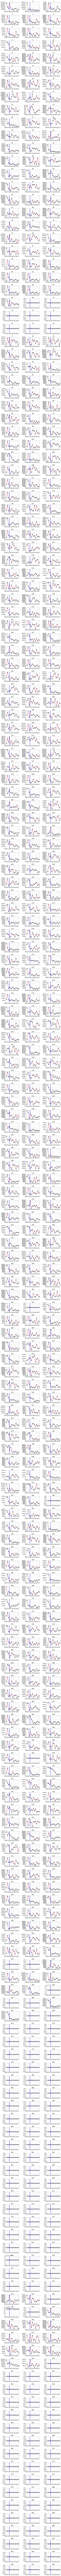

In [18]:
fig = plt.figure(figsize=(10,400), dpi=200)
mtastation = pd.DataFrame(mtastation)

for i in range(0,600):
    ax = fig.add_subplot(200,3,i+1)
    f = np.abs(np.fft.rfft(mtastation.loc[i,:]))
    ax.plot(np.fft.rfftfreq(194,1.0)[1:],f[1:],'o',ms = 8)
    ax.set_title('%i'%(i-1))
    ax.plot(np.fft.rfftfreq(194,1.0)[1:],f[1:],'-')
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52)
    pl.subplots_adjust(wspace=0.5, hspace=0.5, left=0.125,right=0.9,top=1,bottom=0.1)
